# Detector de Texto Gerado por IA (SemEval 2024 - Task 8)

Neste notebook fizemos o fine-tuning de um modelo pré-treinado *roberta-base* para diferenciar textos gerados por humanos de textos gerados por IA.



## Configuração e Instalação

In [2]:
%pip install transformers torch pandas scikit-learn datasets

In [3]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import os
import pyarrow as pa
from datasets import Dataset, load_from_disk, DatasetDict
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
print("Montando Google Drive...")
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Rodando em: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Sem GPU")

Montando Google Drive...
Mounted at /content/drive
Rodando em: cuda
GPU: NVIDIA A100-SXM4-80GB


In [5]:
# caminhos
DRIVE_BASE = "/content/drive/MyDrive/colab_lm/"
SEMEVAL_RAW = os.path.join(DRIVE_BASE, "detec/subtaskA_train_monolingual.jsonl")

# scores de subjetividade
SUBJECTIVITY_SCORES = os.path.join(DRIVE_BASE, "detec/semeval_subjectivity_scores.json")
MODEL_OUTPUT_DIR = os.path.join(DRIVE_BASE, "models/detec_roberta_finetuned")

In [6]:
# config de hardware inteligente
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando device: {device}")

use_bf16 = False
use_fp16 = False

if device.type == 'cuda':
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU Detectada: {gpu_name}")
    if "A100" in gpu_name:
        print("A100 detectada... ativando bfloat16 para máxima velocidade")
        use_bf16 = True
    else:
        print("GPU padrão detectada... ativando float16")
        use_fp16 = True

Usando device: cuda
GPU Detectada: NVIDIA A100-SXM4-80GB
A100 detectada... ativando bfloat16 para máxima velocidade


## Preparação dos dados

Verificamos se o dataset já foi tokenizado e salvo no drive. Se sim, carregamos instantaneamente. Se não, processa e salva.

In [7]:
# ARQUIVOS DE ENTRADA
TRAIN_FILE = os.path.join(DRIVE_BASE, "detec/subtaskA_train_monolingual.jsonl")
TEST_FILE  = os.path.join(DRIVE_BASE, "detec/subtaskA_test_monolingual.jsonl")
GOLD_FILE  = os.path.join(DRIVE_BASE, "detec/subtaskA_gold_monolingual.jsonl")

SUBJECTIVITY_SCORES = os.path.join(DRIVE_BASE, "detec/semeval_subjectivity_scores.json")

print("Carregando datasets")

if not os.path.exists(SUBJECTIVITY_SCORES):
    raise FileNotFoundError("Arquivo de subjetividade não encontrado. Rode o notebook classif-roberta primeiro.")

df_subj = pd.read_json(SUBJECTIVITY_SCORES, lines=True)

# Garantir que não há duplicatas de ID no arquivo de scores
df_subj = df_subj.drop_duplicates(subset=['doc_id'])

print(f"Scores de subjetividade carregados: {len(df_subj)} registros")

print("\nPreparando TREINO...")
df_train_raw = pd.read_json(TRAIN_FILE, lines=True)

# merge com subjetividade
df_train_final = pd.merge(df_train_raw, df_subj, left_on='id', right_on='doc_id', how='inner')
print(f"Treino Final: {len(df_train_final)} linhas (Perdemos {len(df_train_raw) - len(df_train_final)} sem score)")

print("\nPreparando TESTE OFICIAL...")
if os.path.exists(TEST_FILE) and os.path.exists(GOLD_FILE):
    # carrega texto do teste
    df_test_raw = pd.read_json(TEST_FILE, lines=True)

    # gold labels
    df_gold = pd.read_json(GOLD_FILE, lines=True)
    # o gold geralmente tem ['id', 'label'], vamos garantir o merge

    # texto + gold labels
    df_test_labeled = pd.merge(df_test_raw, df_gold[['id', 'label']], on='id', how='inner')

    # renomeando 'label_y' para 'label' e removendo 'label_x'
    df_test_labeled.rename(columns={'label_y': 'label'}, inplace=True)
    df_test_labeled.drop(columns=['label_x'], inplace=True)

    # texto+label + subjetividade
    df_test_final = pd.merge(df_test_labeled, df_subj, left_on='id', right_on='doc_id', how='inner')

    print(f"Teste Oficial Final: {len(df_test_final)} linhas (Perdemos {len(df_test_labeled) - len(df_test_final)} sem score)")

else:
    raise FileNotFoundError("Arquivos de Teste ou Gold Labels não encontrados!")

# Converter para HuggingFace Dataset
# Mantemos as colunas extras para análise posterior
cols_to_keep = ['text', 'label', 'id', 'mean_subjectivity']

train_dataset = Dataset.from_pandas(df_train_final[cols_to_keep])
test_dataset = Dataset.from_pandas(df_test_final[cols_to_keep])

print("\nDatasets prontos: 'train_dataset' (Treino Oficial) e 'test_dataset' (Teste Oficial)")

Carregando datasets
Scores de subjetividade carregados: 119757 registros

Preparando TREINO...
Treino Final: 119757 linhas (Perdemos 0 sem score)

Preparando TESTE OFICIAL...
Teste Oficial Final: 34272 linhas (Perdemos 0 sem score)

Datasets prontos: 'train_dataset' (Treino Oficial) e 'test_dataset' (Teste Oficial)


## Treinamento (Fine-Tuning)

Configurmos o trainer e definimos as métricas (F1 e acurácia). Também verificamos se já existe um modelo treinado para não refazer o trabalho à toa

In [8]:
import os
from datasets import load_from_disk

PROCESSED_DATA_PATH = os.path.join(DRIVE_BASE, "processed_data_cache/semeval_roberta_512")

# Carregar o Tokenizador
model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

# cache
if os.path.exists(PROCESSED_DATA_PATH):
    print(f"Cache encontrado em: {PROCESSED_DATA_PATH}")
    print("Carregando datasets tokenizados do disco (Rápido)...")

    tokenized_train = load_from_disk(os.path.join(PROCESSED_DATA_PATH, "train"))
    tokenized_test = load_from_disk(os.path.join(PROCESSED_DATA_PATH, "test"))

    print(f"Carregado! Treino: {len(tokenized_train)}, Teste: {len(tokenized_test)}")

else:
    print("Cache não encontrado. Iniciando tokenização do zero...")

    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_test = test_dataset.map(tokenize_function, batched=True)

    print(f"Salvando dados tokenizados em: {PROCESSED_DATA_PATH} ...")

    # Salva no disco (Apache Arrow)
    tokenized_train.save_to_disk(os.path.join(PROCESSED_DATA_PATH, "train"))
    tokenized_test.save_to_disk(os.path.join(PROCESSED_DATA_PATH, "test"))

    print("dfados salvos e prontos para uso futuro")

print("Colunas no dataset de teste:", tokenized_test.column_names)
#['text', 'label', 'id', 'mean_subjectivity', 'input_ids', 'attention_mask']

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Cache encontrado em: /content/drive/MyDrive/colab_lm/processed_data_cache/semeval_roberta_512
Carregando datasets tokenizados do disco (Rápido)...
Carregado! Treino: 119757, Teste: 34272
Colunas no dataset de teste: ['text', 'label', 'id', 'mean_subjectivity', 'input_ids', 'attention_mask']


In [11]:
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)

training_args = TrainingArguments(
    output_dir=MODEL_OUTPUT_DIR,
    num_train_epochs=1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,

    fp16=use_fp16,
    bf16=use_bf16,

    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average='macro')
    }

# split de validação interno vindo apenas do treino
train_val_split = tokenized_train.train_test_split(test_size=0.1, seed=42)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_val_split["train"],
    eval_dataset=train_val_split["test"],
    compute_metrics=compute_metrics,
)

print("iniciando treinamento...")
trainer.train()


trainer.save_model(MODEL_OUTPUT_DIR)
tokenizer.save_pretrained(MODEL_OUTPUT_DIR)
print("Modelo de detecção salvo!")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


iniciando treinamento...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.010600,0.016605,0.996326,0.996317


Modelo de detecção salvo!


## **Avaliação**

Aqui carregamos o modelo e fazemos uma avaliação completa no conjunto de validação para gerar o relatório de métricas

Executando predição no teste oficial...



Relatório de Classificação
              precision    recall  f1-score   support

  Humano (0)       0.86      0.72      0.79     16272
      IA (1)       0.78      0.90      0.84     18000

    accuracy                           0.81     34272
   macro avg       0.82      0.81      0.81     34272
weighted avg       0.82      0.81      0.81     34272

Métricas Gerais: {'test_loss': 1.2489981651306152, 'test_accuracy': 0.8148926237161531, 'test_f1': 0.8118304433333483, 'test_runtime': 50.4388, 'test_samples_per_second': 679.477, 'test_steps_per_second': 10.627}


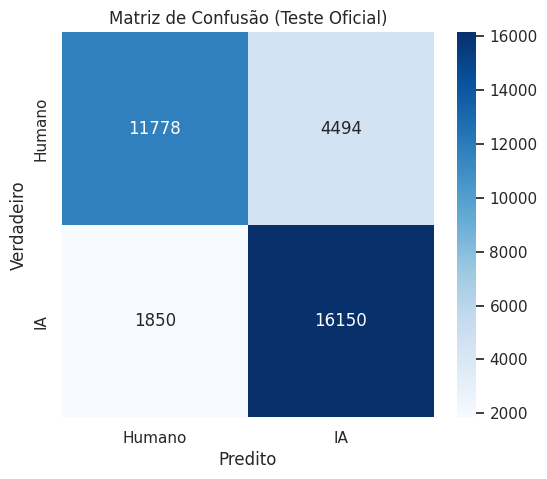

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("Executando predição no teste oficial...")

# Correção: Usamos 'trainer' (que já foi definido) em vez de 'trainer_eval'
results = trainer.predict(tokenized_test)

preds = np.argmax(results.predictions, axis=-1)
labels = results.label_ids

print("\nRelatório de Classificação")
print(classification_report(labels, preds, target_names=['Humano (0)', 'IA (1)']))

print("Métricas Gerais:", results.metrics)

# Matriz de confusão
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Humano', 'IA'], yticklabels=['Humano', 'IA'])
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.title('Matriz de Confusão (Teste Oficial)')
plt.show()

## **Análise**

Gerando previsões para análise...


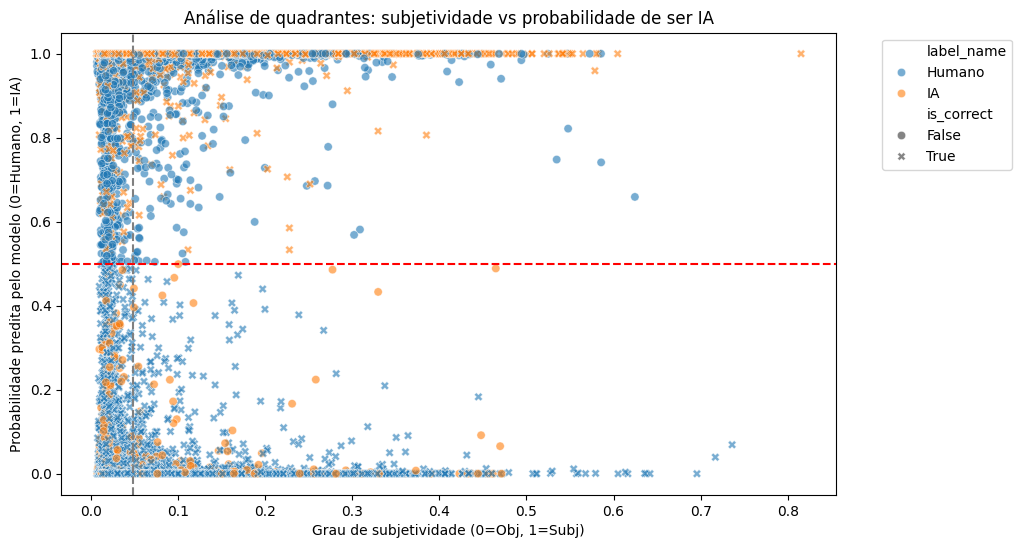

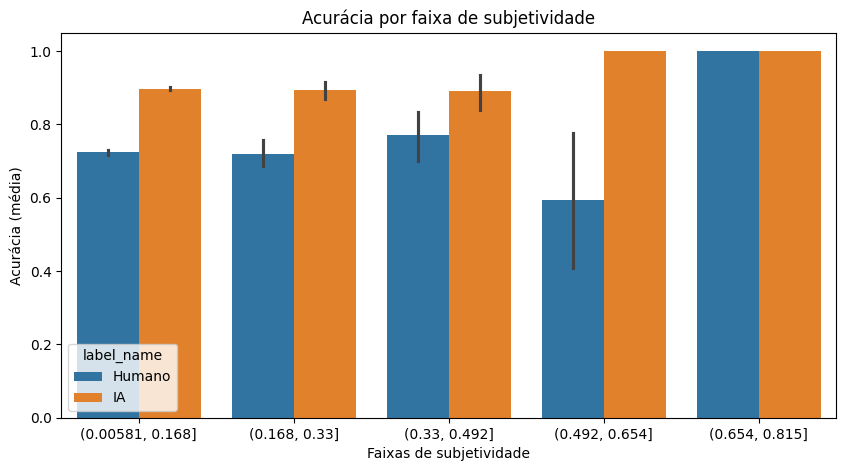


Estatísticas finais
Média de subjetividade nos erros: 0.04835342659386822
Média de subjetividade nos acertos: 0.04848061137547622

Top 5 erros em textos muito subjetivos:
                                                    text  label  \
6998   Do you want to have extra activities in school...      0   
15171  everyone should do community service because i...      0   
13273  Studying Venus is a worthy pursuit despite the...      0   
15900  Going to someone to ask for advice is one of t...      0   
17530  Growing up in a constantly changing environmen...      0   

       predicted_label  mean_subjectivity  
6998                 1           0.624545  
15171                1           0.585807  
13273                1           0.585649  
15900                1           0.572648  
17530                1           0.547896  


In [12]:
print("Gerando previsões para análise...")
predictions_output = trainer.predict(tokenized_test)
preds = np.argmax(predictions_output.predictions, axis=-1)
probs = torch.nn.functional.softmax(torch.tensor(predictions_output.predictions), dim=-1) # Probabilidades

# criar dataframe de análise
# recuperamos os metadados do dataframe original de teste
df_analysis = df_test_final.copy().reset_index(drop=True)
df_analysis['predicted_label'] = preds
df_analysis['confidence_ia'] = probs[:, 1].numpy() # Confiança que é IA
df_analysis['is_correct'] = df_analysis['label'] == df_analysis['predicted_label']

# definir erro/acerto
df_analysis['status'] = df_analysis.apply(
    lambda x: 'Acerto' if x['is_correct'] else 'Erro', axis=1
)

# mapear labels para nomes
label_map = {0: 'Humano', 1: 'IA'}
df_analysis['label_name'] = df_analysis['label'].map(label_map)


# vamos plotar subjetividade (eixo X) vs confiança de ser IA (eixo Y)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_analysis,
    x='mean_subjectivity',
    y='confidence_ia',
    hue='label_name',
    style='is_correct', # X para erro, bolinha para acerto
    alpha=0.6
)
plt.axhline(0.5, color='red', linestyle='--') # linha de decisão
plt.axvline(df_analysis['mean_subjectivity'].mean(), color='gray', linestyle='--') # média de subj
plt.title("Análise de quadrantes: subjetividade vs probabilidade de ser IA")
plt.xlabel("Grau de subjetividade (0=Obj, 1=Subj)")
plt.ylabel("Probabilidade predita pelo modelo (0=Humano, 1=IA)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# taxa de erro por faixa de subjetividade
# criar "bins" de subjetividade
df_analysis['subj_bin'] = pd.cut(df_analysis['mean_subjectivity'], bins=5)

plt.figure(figsize=(10, 5))
sns.barplot(data=df_analysis, x='subj_bin', y='is_correct', hue='label_name')
plt.title("Acurácia por faixa de subjetividade")
plt.ylabel("Acurácia (média)")
plt.xlabel("Faixas de subjetividade")
plt.show()


print("\nEstatísticas finais")
print("Média de subjetividade nos erros:", df_analysis[df_analysis['status']=='Erro']['mean_subjectivity'].mean())
print("Média de subjetividade nos acertos:", df_analysis[df_analysis['status']=='Acerto']['mean_subjectivity'].mean())

# top 5 erros mais subjetivos (onde a IA se confundiu em textos muito opinativos)
print("\nTop 5 erros em textos muito subjetivos:")
print(df_analysis[df_analysis['status']=='Erro'].nlargest(5, 'mean_subjectivity')[['text', 'label', 'predicted_label', 'mean_subjectivity']])

In [13]:
# função para categorizar cada predição
def categorize_prediction(row):
    # label 1 = IA,label 0 = Humano
    if row['label'] == 1 and row['predicted_label'] == 1:
        return "TP (AI Detectada)"
    elif row['label'] == 1 and row['predicted_label'] == 0:
        return "FN (AI -> Humano)"
    elif row['label'] == 0 and row['predicted_label'] == 1:
        return "FP (Humano -> AI)"  # <Onde esperamos alta subjetividade
    elif row['label'] == 0 and row['predicted_label'] == 0:
        return "TN (Humano Correto)"

# aplicar ao dataframe
df_analysis['confusion_category'] = df_analysis.apply(categorize_prediction, axis=1)

# ordem lógica para o gráfico
category_order = [
    "TP (AI Detectada)",
    "FN (AI -> Humano)",
    "FP (Humano -> AI)",
    "TN (Humano Correto)"
]

/tmp/ipython-input-892731683.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


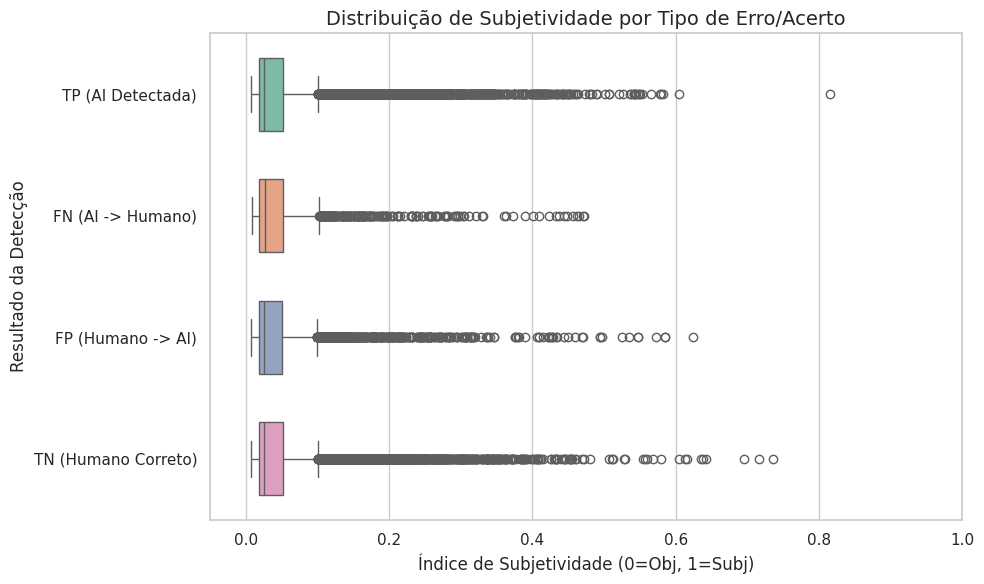

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")


my_palette = {
    "TP (AI Detectada)": "#74c4a7",
    "FN (AI -> Humano)": "#f29e79",
    "FP (Humano -> AI)": "#8da0cb",
    "TN (Humano Correto)": "#e796c1"
}

sns.boxplot(
    data=df_analysis,
    x='mean_subjectivity',
    y='confusion_category',
    order=category_order,
    palette=my_palette,
    showfliers=True, # outliers
    width=0.6
)

plt.title('Distribuição de Subjetividade por Tipo de Erro/Acerto', fontsize=14)
plt.xlabel('Índice de Subjetividade (0=Obj, 1=Subj)', fontsize=12)
plt.ylabel('Resultado da Detecção', fontsize=12)
plt.xlim(-0.05, 1.0)
plt.tight_layout()
plt.show()

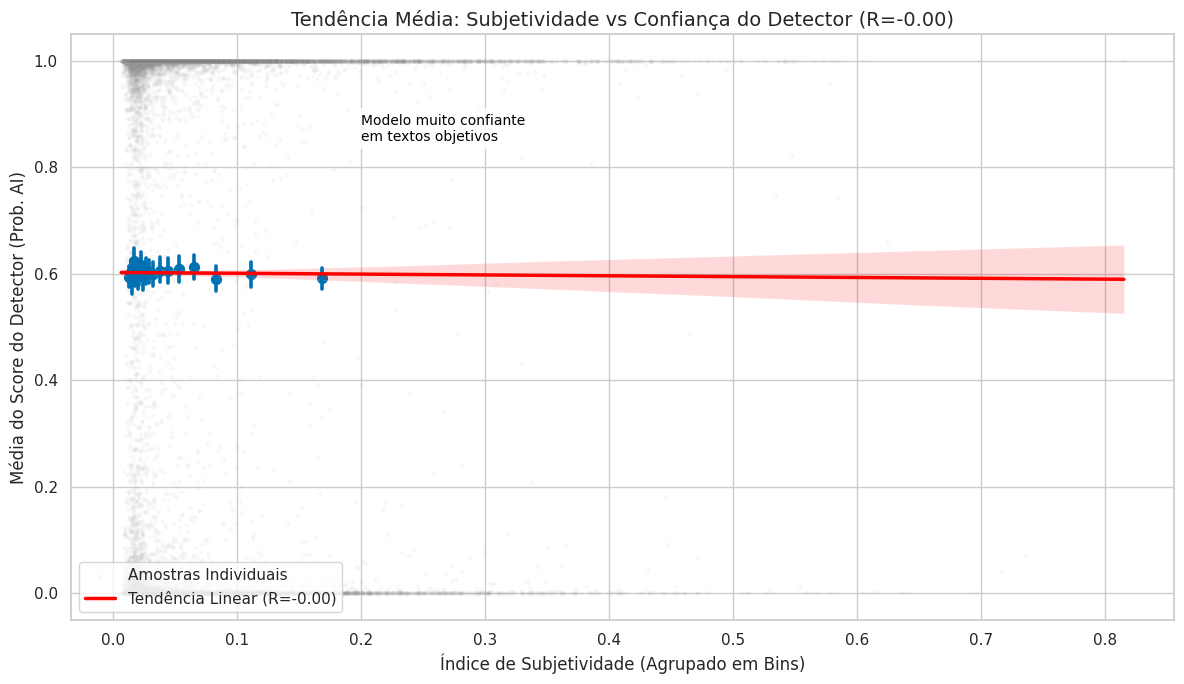

In [15]:
from scipy.stats import pearsonr

# Calcular correlação de Pearson (R)
corr, _ = pearsonr(df_analysis['mean_subjectivity'], df_analysis['confidence_ia'])

plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid")

# Plotar os pontos de fundo (Scatter) bem transparentes para ver a massa de dados
sns.scatterplot(
    data=df_analysis,
    x='mean_subjectivity',
    y='confidence_ia',
    color='gray',
    alpha=0.05, # Bem transparente
    s=10,
    label='Amostras Individuais'
)

# Plotar a Regressão com Bins
# x_bins=20 vai dividir o eixo X em 20 partes e calcular a média de cada parte
sns.regplot(
    data=df_analysis,
    x='mean_subjectivity',
    y='confidence_ia',
    x_bins=20,
    color='#0072B2', # Cor dos pontos médios
    line_kws={"color": "red", "linewidth": 2.5, "label": f"Tendência Linear (R={corr:.2f})"},
    scatter_kws={"s": 50, "alpha": 1}
)

# Anotações e Limites
plt.title(f'Tendência Média: Subjetividade vs Confiança do Detector (R={corr:.2f})', fontsize=14)
plt.xlabel('Índice de Subjetividade (Agrupado em Bins)', fontsize=12)
plt.ylabel('Média do Score do Detector (Prob. AI)', fontsize=12)
plt.ylim(-0.05, 1.05)

# Adicionar anotação de texto
plt.text(0.2, 0.85, "Modelo muito confiante\nem textos objetivos", fontsize=10, color='black',
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [16]:
# filtrar apenas os textos mais subjetivos ( > 0.5)
df_high_subj = df_analysis[df_analysis['mean_subjectivity'] > 0.5].copy()

print(f"Total de textos altamente subjetivos (>0.5): {len(df_high_subj)}")

# Calcular a acurácia NESSE subgrupo específico
acc_high_subj = df_high_subj['is_correct'].mean()
print(f"Acurácia no subgrupo Subjetivo: {acc_high_subj:.2%}")

# Comparar com a acurácia geral
# Calculamos a média da coluna 'is_correct' de todo o dataframe de análise
acc_general = df_analysis['is_correct'].mean()
print(f"Acurácia Geral (Todo o dataset): {acc_general:.2%}")

# Ver a confusão nesse subgrupo
print("\nMatriz de Confusão (Apenas Alta Subjetividade)")
print(df_high_subj['confusion_category'].value_counts(normalize=True))

Total de textos altamente subjetivos (>0.5): 49
Acurácia no subgrupo Subjetivo: 83.67%
Acurácia Geral (Todo o dataset): 81.49%

Matriz de Confusão (Apenas Alta Subjetividade)
confusion_category
TP (AI Detectada)      0.448980
TN (Humano Correto)    0.387755
FP (Humano -> AI)      0.163265
Name: proportion, dtype: float64
